In [60]:
import keras
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from collections import Counter
from keras.applications import VGG16, EfficientNetV2S
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [61]:
# train_dir = "../input/impressionist-classifier-data/training/training"
# validation_dir =  '../input/impressionist-classifier-data/validation/validation'
data_dir = "../input/flowers-recognition/flowers"
batchsize = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# cla = ["Moon_jellyfish", "barrel_jellyfish", "blue_jellyfish", "compass_jellyfish", 
#                 "lions_mane_jellyfish", "mauve_stinger_jellyfish"]
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        data_dir,
        #classes=cla,
        target_size=(150, 150),
        batch_size=batchsize,
        class_mode='categorical', 
        shuffle=True,
        subset = 'training',
        seed=42)

validation_generator = test_datagen.flow_from_directory(
        data_dir,
        #classes=cla,
        target_size=(150, 150),
        batch_size=batchsize,
        class_mode='categorical', 
        shuffle=True,
        subset = 'validation',
        seed=42)

print(Counter(train_generator.classes))
print(Counter(validation_generator.classes))
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Counter({1: 842, 4: 788, 2: 628, 0: 612, 3: 587})
Counter({1: 210, 4: 196, 2: 156, 0: 152, 3: 146})
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 5)


In [53]:
model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3),(1,1),  
#                         activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),  strides=(2, 2)))
# model.add(layers.GlobalAveragePooling2D()) # zamiast flatten 
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(5, activation='softmax'))
# print(model.summary())
model.add(layers.Conv2D(32, (4, 4), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalAveragePooling2D()) # good if overfitting, less parameters than flatten
model.add(layers.Dense(5, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

# zastój na validation loss, ekspoatacja minimum, zmniejsz leraning rate (krok gradientu), patience - ile epok na płaskowyżu
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/model_test.h5',
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
num_train_imgs = 3457
num_test_imgs = 860


history = model.fit(
      train_generator,
      steps_per_epoch=num_train_imgs//batchsize,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=num_test_imgs//batchsize, 
      callbacks = [lrd, earlystopping, checkpoint])


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 70, 70, 64)        32832     
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 35, 35, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 16, 16, 64)      

2024-01-10 15:15:43.143473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - ETA: 0s - loss: 1.4124 - acc: 0.3553
Epoch 1: val_loss improved from inf to 1.43972, saving model to /kaggle/working/model_test.h5
108/108 [==============================] - 38s 327ms/step - loss: 1.4124 - acc: 0.3553 - val_loss: 1.4397 - val_acc: 0.3882 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 1.2963 - acc: 0.4455
Epoch 2: val_loss improved from 1.43972 to 1.23164, saving model to /kaggle/working/model_test.h5
108/108 [==============================] - 32s 295ms/step - loss: 1.2963 - acc: 0.4455 - val_loss: 1.2316 - val_acc: 0.5204 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 1.1866 - acc: 0.5188
Epoch 3: val_loss improved from 1.23164 to 1.15234, saving model to /kaggle/working/model_test.h5
108/108 [==============================] - 30s 275ms/step - loss: 1.1866 - acc: 0.5188 - val_loss: 1.1523 - val_acc: 0.5433 - lr: 0.0010
Epoch 4/100
108/108 [==============

In [ ]:
# Epoch 31: val_loss did not improve from 0.74899
# 108/108 [==============================] - 29s 268ms/step - loss: 0.6987 - acc: 0.7375 - val_loss: 0.8158 - val_acc: 0.7151 - lr: 2.5000e-04

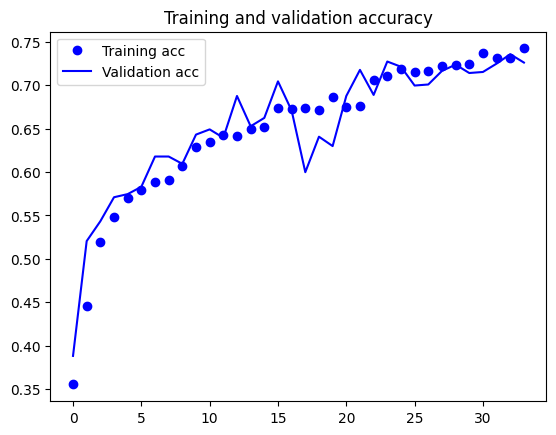

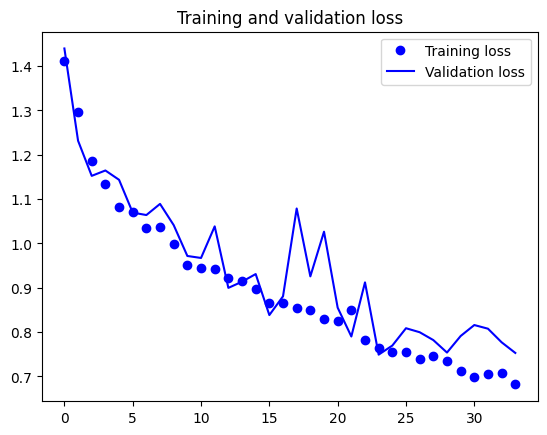

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [86]:
conv_base = EfficientNetV2S(weights="imagenet",
                  include_top=False,
                  include_preprocessing=False,
                  input_shape=(150, 150, 3))

# conv_base.summary()

In [87]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 5, 5, 1280)        20331360  
 al)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 5, 5, 1280)        0         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_41 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 20337765 (77.58 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [81]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/model2.h5',
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
num_train_imgs = 3457
num_test_imgs = 860


history = model.fit(
      train_generator,
      steps_per_epoch=num_train_imgs//batchsize,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=num_test_imgs//batchsize, 
      callbacks = [lrd, earlystopping, checkpoint])


Epoch 1/100


2024-01-10 17:35:07.027255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - ETA: 0s - loss: 0.8616 - acc: 0.7066
Epoch 1: val_loss improved from inf to 0.54589, saving model to /kaggle/working/model2.h5
108/108 [==============================] - 47s 299ms/step - loss: 0.8616 - acc: 0.7066 - val_loss: 0.5459 - val_acc: 0.7981 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 0.5686 - acc: 0.8058
Epoch 2: val_loss improved from 0.54589 to 0.44688, saving model to /kaggle/working/model2.h5
108/108 [==============================] - 28s 262ms/step - loss: 0.5686 - acc: 0.8058 - val_loss: 0.4469 - val_acc: 0.8438 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 0.5071 - acc: 0.8190
Epoch 3: val_loss improved from 0.44688 to 0.42635, saving model to /kaggle/working/model2.h5
108/108 [==============================] - 28s 261ms/step - loss: 0.5071 - acc: 0.8190 - val_loss: 0.4263 - val_acc: 0.8474 - lr: 0.0010
Epoch 4/100
108/108 [==========================

In [ ]:
# Epoch 33: val_loss did not improve from 0.32132
# 108/108 [==============================] - 27s 252ms/step - loss: 0.2979 - acc: 0.8931 - val_loss: 0.3348 - val_acc: 0.8846 - lr: 5.0000e-04
# Epoch 33: early stopping

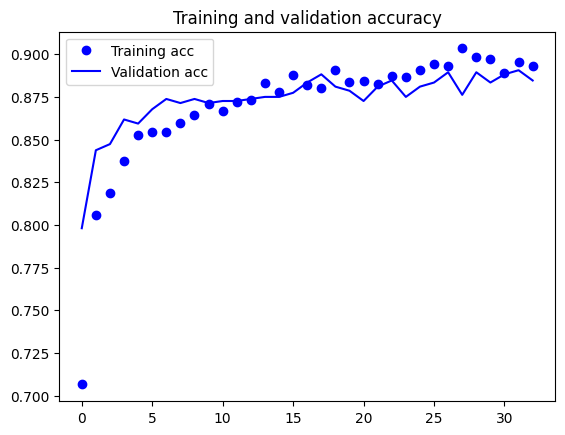

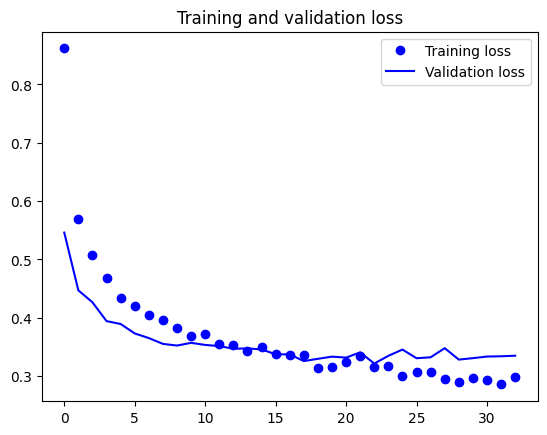

In [82]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [88]:
conv_base.trainable = True

# set_trainable = False
# freeze 5 first layers
for layer in conv_base.layers[:-5]:
        layer.trainable = False

# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [89]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/model3.h5',
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
num_train_imgs = 3457
num_test_imgs =860


history = model.fit(
      train_generator,
      steps_per_epoch=num_train_imgs//batchsize,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=num_test_imgs//batchsize, 
      callbacks = [lrd, earlystopping, checkpoint])

Epoch 1/100


2024-01-10 19:02:09.758361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_30/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - ETA: 0s - loss: 0.5862 - acc: 0.7819
Epoch 1: val_loss improved from inf to 0.35018, saving model to /kaggle/working/model3.h5
108/108 [==============================] - 47s 291ms/step - loss: 0.5862 - acc: 0.7819 - val_loss: 0.3502 - val_acc: 0.8702 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 0.3862 - acc: 0.8596
Epoch 2: val_loss improved from 0.35018 to 0.31143, saving model to /kaggle/working/model3.h5
108/108 [==============================] - 30s 275ms/step - loss: 0.3862 - acc: 0.8596 - val_loss: 0.3114 - val_acc: 0.8846 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 0.3083 - acc: 0.8940
Epoch 3: val_loss did not improve from 0.31143
108/108 [==============================] - 28s 256ms/step - loss: 0.3083 - acc: 0.8940 - val_loss: 0.3126 - val_acc: 0.8906 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - ETA: 0s - loss: 0.2846 - acc: 0.8987
Ep

In [ ]:
# Epoch 10: val_loss improved from 0.33076 to 0.31224, saving model to /kaggle/working/model3.h5
# 108/108 [==============================] - 29s 273ms/step - loss: 0.1468 - acc: 0.9480 - val_loss: 0.3122 - val_acc: 0.9026 - lr: 0.0010

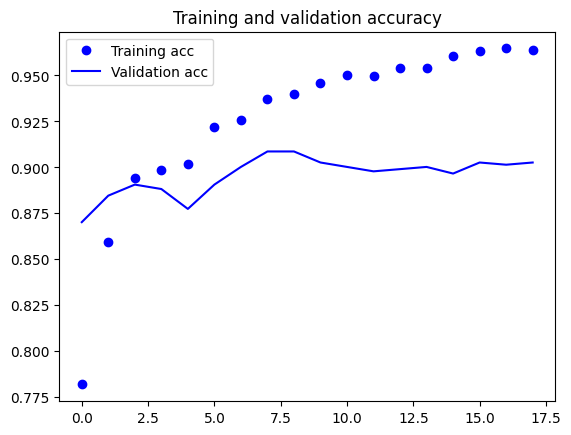

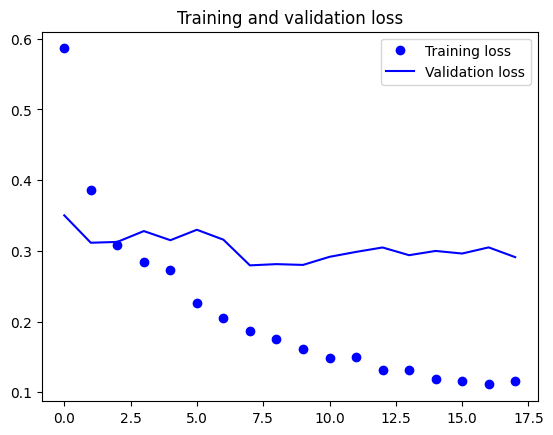

In [90]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
# model bez augumentacji

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3),(1,1),  
#                         activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2),  strides=(2, 2)))
# model.add(layers.GlobalAveragePooling2D()) # zamiast flatten 
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(5, activation='softmax'))
# print(model.summary())

model = models.Sequential()
model.add(layers.Conv2D(32, (4, 4), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(5, activation='softmax'))
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 70, 70, 64)        32832     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 35, 35, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 32, 32, 64)        65600     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 16, 16, 64)      

In [56]:
# train_dir = "../input/impressionist-classifier-data/training/training"
# validation_dir =  '../input/impressionist-classifier-data/validation/validation'
data_dir = "../input/flowers-recognition/flowers"
batchsize = 32

train_datagen = ImageDataGenerator(
    rescale=1./255, validation_split=0.2)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# cla = ["Moon_jellyfish", "barrel_jellyfish", "blue_jellyfish", "compass_jellyfish", 
#                 "lions_mane_jellyfish", "mauve_stinger_jellyfish"]
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        data_dir,
     #classes=cla,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=batchsize,
        class_mode='categorical', 
        shuffle=True,
        subset = 'training',
        seed=42)

validation_generator = test_datagen.flow_from_directory(
        data_dir,
     #classes=cla,
        target_size=(150, 150),
        batch_size=batchsize,
        class_mode='categorical', 
        shuffle=True,
        subset = 'validation',
        seed=42)

print(Counter(train_generator.classes))
print(Counter(validation_generator.classes))
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Counter({1: 842, 4: 788, 2: 628, 0: 612, 3: 587})
Counter({1: 210, 4: 196, 2: 156, 0: 152, 3: 146})
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 5)


In [57]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

# zastój na validation loss, ekspoatacja minimum, zmniejsz leraning rate (krok gradientu), patience - ile epok na płaskowyżu
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/model_4.h5',
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
num_train_imgs = 3457
num_test_imgs = 860


history = model.fit(
      train_generator,
      steps_per_epoch=num_train_imgs//batchsize,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=num_test_imgs//batchsize, 
      callbacks = [lrd, earlystopping, checkpoint])


Epoch 1/100


2024-01-10 16:02:45.454786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


108/108 [==============================] - ETA: 0s - loss: 1.4172 - acc: 0.3705
Epoch 1: val_loss improved from inf to 1.28935, saving model to /kaggle/working/model_4.h5
108/108 [==============================] - 18s 152ms/step - loss: 1.4172 - acc: 0.3705 - val_loss: 1.2893 - val_acc: 0.4255 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 1.2034 - acc: 0.4867
Epoch 2: val_loss improved from 1.28935 to 1.14019, saving model to /kaggle/working/model_4.h5
108/108 [==============================] - 12s 110ms/step - loss: 1.2034 - acc: 0.4867 - val_loss: 1.1402 - val_acc: 0.5276 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 1.1243 - acc: 0.5550
Epoch 3: val_loss did not improve from 1.14019
108/108 [==============================] - 12s 110ms/step - loss: 1.1243 - acc: 0.5550 - val_loss: 1.1819 - val_acc: 0.5204 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - ETA: 0s - loss: 1.0695 - acc: 0.5787


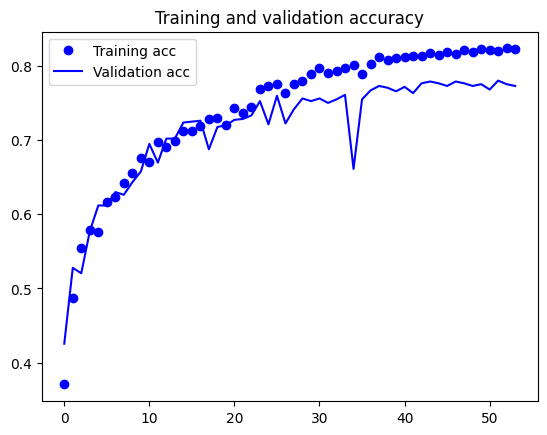

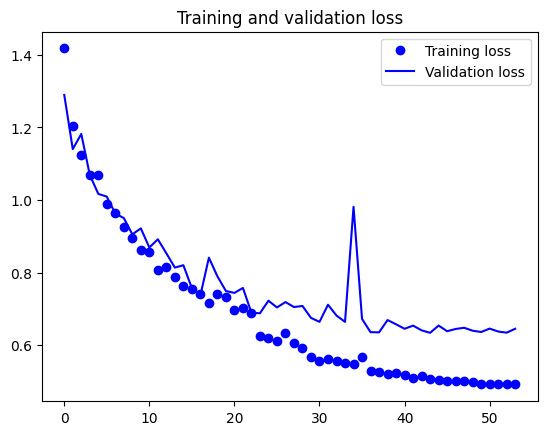

In [58]:
# Epoch 52: val_loss did not improve from 0.63430
# 108/108 [==============================] - 11s 106ms/step - loss: 0.4921 - acc: 0.8196 - val_loss: 0.6379 - val_acc: 0.7800 - lr: 3.1250e-05


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()